# Assignment 2


You must submit your notebook by running `python3 -m autograder.run.submit Assignment2.ipynb` from your local repository.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. To do so, restart the kernel and run all cells (in the menubar, select Runtime→→Restart and run all).

#### Show your work!
Whenever you are asked to find the solution to a problem, be sure to also **show how you arrived** at your answer.

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWERS HERE", as well as your name below:

## Some Helper Functions

Implement an evaluation function that takes in some board position and player colour and returns a score. 

In [61]:
import chess
import random
from math import inf, exp, pow
from IPython.display import display, clear_output

In [62]:
piece_values = {
    chess.PAWN: 1,
    chess.KNIGHT: 3,
    chess.BISHOP: 3,
    chess.ROOK: 5,
    chess.QUEEN: 9,
    chess.KING: 200  # King is invaluable
}

def evaluation(b: chess.Board, player: bool):
    """
    This function evaluates a board position and returns a score value.
    
    Parameters:
    - board: the chess board that the knight is moving upon
    - player: the colour of the active player (True -> white, False -> black)
    
    Returns:
    - an integer score for a board state
    """
    # Define weights for each factor in the linear function
    WEIGHT_MATERIAL = 1.0
    WEIGHT_MOBILITY = 0.1
    WEIGHT_STRUCTURE = 0.5
    
    # Compute the individual evaluation components
    material_score = evaluate_material(b)
    mobility_score = evaluate_mobility(b)
    structure_score = evaluate_structure(b)
     
    return (WEIGHT_MATERIAL * material_score) + (WEIGHT_MOBILITY * mobility_score) + (WEIGHT_STRUCTURE * structure_score)

def evaluate_material(b:chess.Board):
    score = 0
    for color in [chess.WHITE, chess.BLACK]:    
        for piece, value in piece_values.items():
            num_of_pieces =  len(list(b.pieces(piece, color)))
            score += num_of_pieces * value if color == chess.WHITE else (-1 * num_of_pieces *value)
    return score

def evaluate_mobility(b:chess.Board):
    white_moves = 0
    black_moves = 0
    
    if(b.turn == chess.WHITE):
        white_moves = len(list(b.legal_moves))
    else:
        black_moves =  len(list(b.legal_moves))
    
    b.turn = not b.turn
    
    if(b.turn == chess.WHITE):
        white_moves = len(list(b.legal_moves))
    else:
        black_moves =  len(list(b.legal_moves))

    b.turn = not b.turn
    return white_moves - black_moves

def evaluate_structure(b:chess.Board):
    score = 0
    score += evaluate_pawn_structure(b)
    # score += evaluate_king_safety(b)
    return score


def evaluate_pawn_structure(b:chess.Board):
    score = 0 
    for color in [chess.WHITE, chess.BLACK]:
        pawns = b.pieces(chess.PAWN, color)
        # checking for double pawns
        file_count = [0] * 8
        for pawn in pawns:
            file = chess.square_file(pawn)
            file_count[file] += 1
        # penalty for double pawn
        for count in file_count:
            if count > 1:
                score -= count * (.5 if color == chess.WHITE else -.5)
        # penalty for isolated pawns
        for pawn in pawns:
            file = chess.square_file(pawn)
            is_isolated = True
            if file > 0 and len(b.pieces(chess.PAWN, color) & chess.BB_FILES[file-1]) > 0:
                is_isolated = False
            if file < 7 and len(b.pieces(chess.PAWN, color) & chess.BB_FILES[file+1]) > 0:
                is_isolated = False
            if is_isolated:
                score -= 1 if color == chess.WHITE else -1
        # penalty for blocked pawns
        for pawn in pawns:
            if color == chess.WHITE:
                if b.piece_at(pawn + 8) is not None:
                    score -= 0.5
            else: 
                if b.piece_at(pawn - 8) is not None:
                    score += 0.5
                
    return score

def evaluate_king_safety(b:chess.Board):
    score = 0
    for color in [chess.WHITE, chess.BLACK]:
        king_square = b.king(color)
        if not king_square: return score
        rank = chess.square_rank(king_square)
        file = chess.square_file(king_square)
        
        if color == chess.WHITE and rank > 0:
            if b.piece_at(chess.square(file, rank - 1)) == chess.PAWN:
                score += 0.5
        elif color == chess.BLACK and rank < 7:
            if b.piece_at(chess.square(file, rank -1 )) == chess.PAWN:
                score += 0.5    
    return score
    

## Q1

Implement the minimax algorithm to choose the best chess move for a given board position, player colour, and look-ahead depth. Make use of your `evaluation()` function here to calculate the score of any individual board state.

In [63]:
def get_minimax_move(b: chess.Board, player: bool, depth: int):   
    """
    This function chooses the best move for the given board position, player, and depth.
    Parameters:
    - board: the chess board that the knight is moving upon
    - player: the colour of the active player (True -> white, False -> black)
    - depth: the number of moves that the algorithmn should look ahead.
    
    Returns:
    A single chess.Move type object.
    """
    # limit to a depth of 6-8 to not fry computer

    def helper(local_b:chess.Board, local_player:bool, local_depth:int, alpha:float, beta:float):
        # YOUR CODE HERE
        if local_depth == 0 or local_b.outcome():
            return evaluation(local_b, local_player), None
        best_move = None
        if(local_player == chess.WHITE):
            v = float('-inf')
            for move in local_b.legal_moves:
                new_board = local_b.copy()
                new_board.push(move)
                move_value, _ =  helper(new_board, chess.BLACK, local_depth-1, alpha, beta)
                if move_value > v:
                    v = move_value
                    best_move = move
                alpha = max(alpha, v)
                if alpha >= beta:
                    break   
            return v, best_move
        if(local_player == chess.BLACK):
            v = float('inf')
            for move in local_b.legal_moves:
                new_board = local_b.copy()
                new_board.push(move)
                move_value,_ = helper(new_board, chess.BLACK, local_depth-1, alpha, beta)
                if move_value < v:
                    v = move_value
                    best_move = move
                beta = min(beta, v)
                if alpha >= beta:
                    break
            return v, best_move

    # YOUR CODE HERE
    _,best_move = helper(b, player, depth, float('-inf'), float('inf'))
    return best_move

## Q2

Implement the expectimax algorithm to choose the best chess move for a given board position, player colour, and look-ahead depth. Make use of your `evaluation()` function here to calculate the score of any individual board state.

In [64]:
def get_expectimax_move(b: chess.Board, player: bool, depth: int):   
    """
    This function chooses the best move for the given board position, player, and depth.
    
    Parameters:
    - board: the chess board that the knight is moving upon
    - player: the colour of the active player (True -> white, False -> black)
    - depth: the number of moves that the algorithm should look ahead.
    
    Returns:
    A single chess.Move type object.
    """    
    def softmax(values):
        exp_values = [exp(value) for value in values]
        total = sum(exp_values)
        probabilities = [exp_value / total for exp_value in exp_values]
        return probabilities
    
    def helper(local_b:chess.Board, local_player:bool, local_depth:int):
        # YOUR CODE HERE
        if local_depth == 0 or local_b.outcome():
            return evaluation(local_b, local_player), None
        best_move = None
        if(local_player == chess.WHITE):
            v = 0
            for move in local_b.legal_moves:
                new_board = local_b.copy()
                new_board.push(move)
                move_value, _= helper(new_board, chess.BLACK, local_depth-1)
                if move_value > v:
                    v = move_value
                    best_move = move
            return v , best_move
        if(local_player == chess.BLACK):
            legal_moves = list(local_b.legal_moves)
            move_values = []
            for move in local_b.legal_moves:
                new_board = local_b.copy()
                new_board.push(move)
                move_value, _ = helper(new_board, chess.WHITE, local_depth-1)
                move_values.append(move_value)

            move_probabilities = softmax(move_values)
            expected_value = sum( p * v for p, v in zip(move_probabilities, move_values))
            return expected_value, None

    # YOUR CODE HERE
    _,best_move = helper(local_b=b,local_player=player,local_depth=depth)
    return best_move
        

## Q3

Plays against the strongest grading agent, so copy your best agent here.

In [65]:
def get_best_move(b: chess.Board, player: bool, depth: int):   
    """
    This function chooses the best move for the given board position, player, and depth.
    
    Parameters:
    - board: the chess board that the knight is moving upon
    - player: the colour of the active player (True -> white, False -> black)
    - depth: the number of moves that the algorithmn should look ahead.
    
    Returns:
    A single chess.Move type object.
    """    
    
    # YOUR CODE HERE
    return get_minimax_move(b=b,player=player, depth=depth)

## Local Testing
For your convenience, here are some helper functions to run games and allow you to test your agents.

In [66]:
def get_random_move(b:chess.Board, *_):
    rand = random.Random(0)
    return rand.choice(list(b.legal_moves))

In [67]:
MAX_DEPTH = 3
SEED = random.Random(0)  # Feel free to set/reset the seed for testing purposes!

def get_random_move(b:chess.Board, *_):
    return SEED.choice(list(b.legal_moves))

def test_game(p1, p2):
    """
    A function that plays a chess game with visuals
    
    Parameters:
    - p1: the first chess agent, playing as the white player
    - p2: the second chess agent, playing as the black player
    
    Returns:
    Nothing, just plays the game one move at a time.
    Press enter in the popup box to play the next move.
    Type 'q' into the popup box and press enter to stop the game (you can also interrupt the kernel if this fails.)
    """
    board = chess.Board()
    current_player = p1

    while not board.is_checkmate()  and not board.is_stalemate() and not board.can_claim_draw():
        clear_output(True)
        
        move = current_player(board, board.turn, MAX_DEPTH)
        board.push(move)
        display(board)

        current_player = p1 if board.turn else p2

        if input() == "q":
            break
    

In [ ]:
# Random Vs. Random
random_agent = get_random_move
test_game(random_agent, random_agent)

In [ ]:
# Minimax Vs. Random
random_agent = get_random_move
minimax_agent = get_minimax_move
test_game(minimax_agent, random_agent)


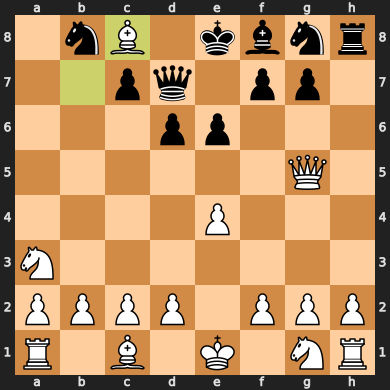

In [68]:
# Expectimax Vs. Random
random_agent = get_random_move
expectimax_agent = get_expectimax_move
test_game(expectimax_agent, random_agent)

In [56]:
# Run several games at once without graphics
def grade_game(p1, p2):
    """
    Grades a single game at a time.
    (Note: differs from actual grading script, which has some ways to resolve draws.)

    Return legend:
    0: error during game
    1: p1 wins through checkmate
    2: p2 wins through checkmate
    3: draw
    """
    board = chess.Board()
    current_player = p1

    while not board.is_checkmate() and not board.is_stalemate() and not board.can_claim_draw():
        move = current_player(board,board.turn, MAX_DEPTH)
        try:
            board.push(move)
        except:            
            print(f"Error while grading game, move = {move}, current_player = {current_player}")
            print(board)
            return -1

        current_player = p1 if board.turn else p2
    
    outcome = board.outcome()
    if outcome is not None:
        if outcome.winner:
            return 1
        else:
            return 2
    
    return 3

In [58]:
# Play many games in a row without visuals (faster)
random_agent = get_random_move
best_agent = get_best_move
num_games = 5

print(f"Playing {num_games} games...")
for i in range(1, num_games+1):
    result = grade_game(best_agent, random_agent)

    if result == 0:
        print(f"Game {i}: error pushing a move during gameplay")
        
    elif result == 1:
        print(f"Game {i}: p1 wins")
        
    elif result == 2:
        print(f"Game {i}: p1 loses")
    
    elif result == 3:
        print(f"Game {i}: draw")

Playing 5 games...


KeyboardInterrupt: 